<a href="https://colab.research.google.com/github/salmanromeo/shafi/blob/master/1D_Pitching_Moment_PyMC/1D_Pitching_Moment_PyMC_Shafi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inverse problem parameterization of 1D Pitching Moment Equation for Blunt-Body Entry Vehicles unsing PyMC**

#####We will apply Bayesian methods to 1D Pitching Moment problem, to show an end-to-end Bayesian analysis to identify some unknown parameters with prior probabilities and will implement in final posterior distribution.

**Instal pymc3**

In [ ]:
pip install pymc3

**Environment**

In [2]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
import pymc3 as pm
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import arviz as az
az.style.use("arviz-darkgrid")
from IPython.display import display
#import pymc as pm
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

**Define a model**

In [11]:
def model(t, CM_a, CM_q_a):
    # Parameter setup
    A       = 1
    ro      = 1.20
    v       = 858
    s       = 0.00385
    d       = 0.07
    I       = 1.55e-4
    dlt     = 0
    # Equations
    w = np.sqrt(-((ro*v**2*s*d*CM_a)/(2*I))) 
    cos = np.cos(w*t + dlt)
    e = (ro*v*s*d**2)*(CM_q_a)/(8*I)
    exp = np.exp(e*t)
    x = A*exp*cos
    return x

**Generating data**

In [13]:
n = 300
sig = 0.02
t = np.linspace(0,0.3,n)

**The analytical solution to the 1D Pitching Moment Equation**

In [14]:
# True Values
np.random.seed(seed=1)
A       = 1
ro      = 1.20
v       = 858
s       = 0.00385
d       = 0.07
CM_q_a  = 0
CM_a    = -0.09
I       = 1.55e-4
dlt     = 0
# Equations
w = np.sqrt(-((ro*v**2*s*d*CM_a)/(2*I)))    # w is omega
cos = np.cos(w*t + dlt)
e = (ro*v*s*d**2)*(CM_q_a)/(8*I)            # e is epsilon
exp = np.exp(e*t)
f_e = A*exp*cos + np.random.normal(0,sig,t.shape)

**Generate observation data**

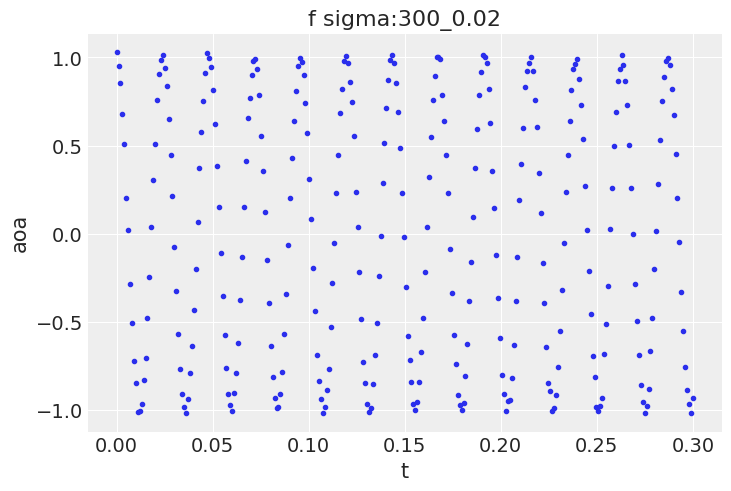

In [19]:
plt.plot(t,f_e,'.')
plt.gca().update(dict(title=('f sigma:'+str(n)+"_"+str(sig)), xlabel='t', ylabel='aoa'))
plt.savefig('/content/sample_data/plots/f'+str(n)+"_"+str(sig)+'.png')

**Define PyMC model**

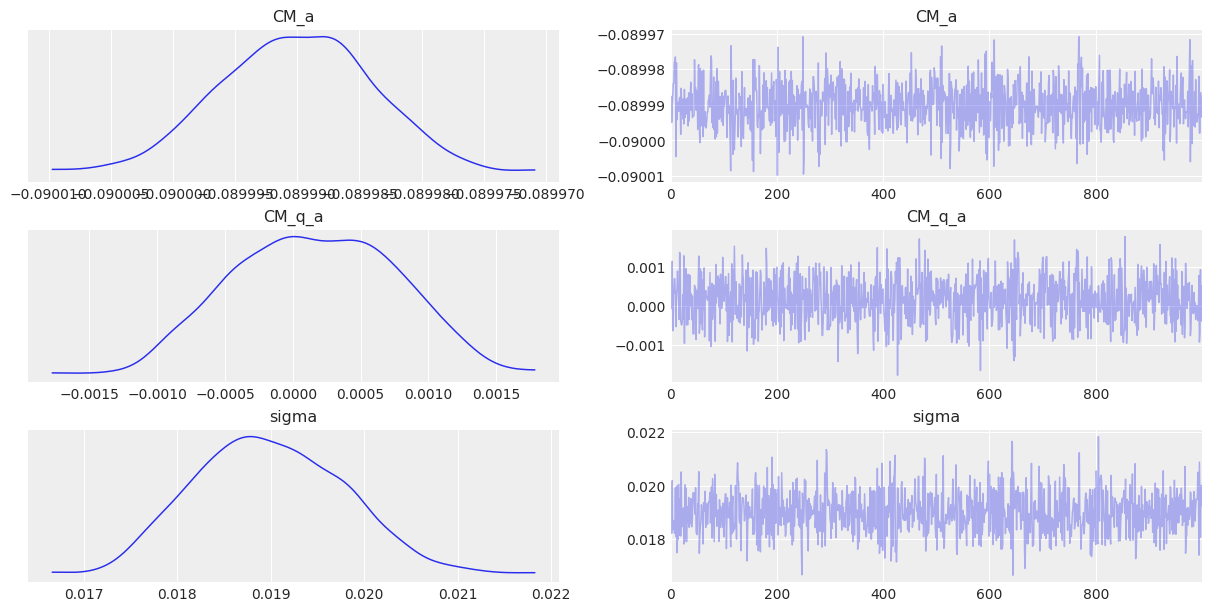

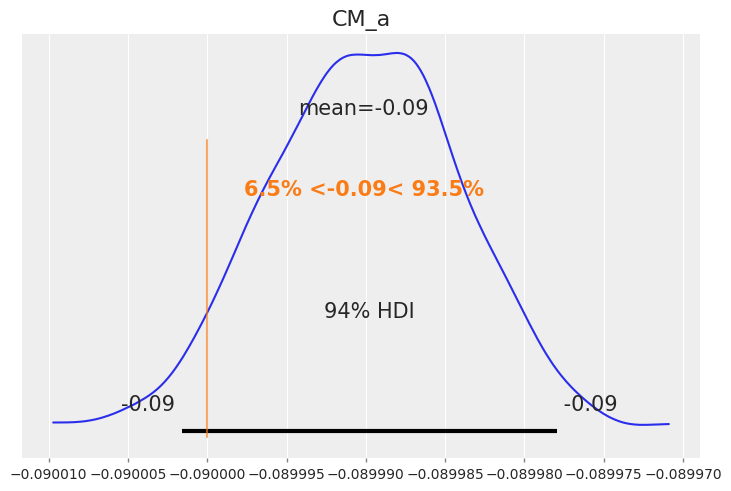

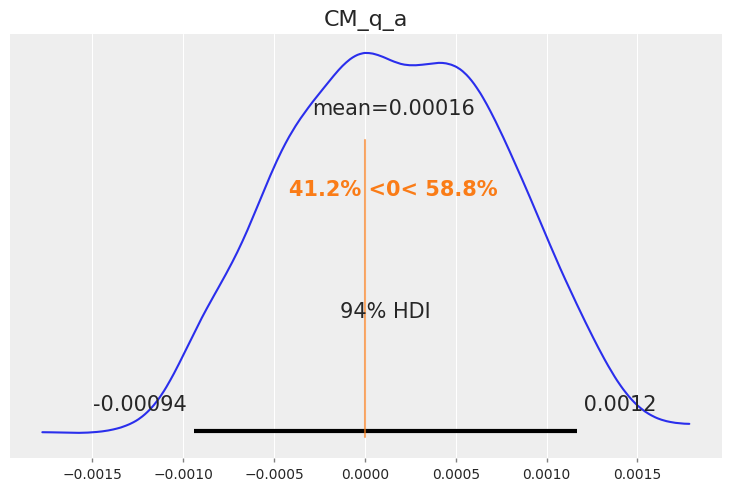

Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
CM_a,-0.0900,0.0000,-0.0900,-0.0900,0.0,0.0,1510.8958,628.3227,NaN
CM_q_a,0.0002,0.0006,-0.0009,0.0012,0.0,0.0,1273.7541,761.8169,NaN
sigma,0.0190,0.0008,0.0175,0.0204,0.0,0.0,1276.5753,783.2534,NaN


In [18]:
# define model
basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters
    CM_a = pm.Uniform("CM_a", lower=-0.15, upper=-0.01)
    CM_q_a = pm.Uniform("CM_q_a", lower=-1, upper=1)

    # Expected & Observed values
    A       = 1
    ro      = 1.20
    v       = 858
    s       = 0.00385
    d       = 0.07
    # CM_q_a  = 0
    # CM_a    = -0.09
    I       = 1.55e-4
    dlt     = 0
    # Equations
    w = np.sqrt(-((ro*v**2*s*d*CM_a)/(2*I)))    # w is omega
    cos = np.cos(w*t + dlt)
    e = (ro*v*s*d**2)*(CM_q_a)/(8*I)            # e is epsilon
    exp = np.exp(e*t)
    f = A*exp*cos
    observed = f_e

    # Likelihood (sampling distribution) of observations
    sigma = pm.HalfNormal("sigma", sd=0.1)
    func = pm.Normal("func", mu=f,sd=sigma,observed=observed)

# trace/sample model
with basic_model:
    trace = pm.sample(1000, chains=1)

# plot outputs
with basic_model:
    pm.plot_trace(trace) # pm.plot_trace(trace,['nu','sigma'])
    plt.show()
    az.plot_posterior(trace,['CM_a'],ref_val=-0.09)
    plt.xticks(fontsize=10)
    plt.savefig('/content/sample_data/plots/c'+str(n)+"_"+str(sig)+'.png')
    plt.show()
    az.plot_posterior(trace,['CM_q_a'],ref_val=0)
    plt.xticks(fontsize=10)
    plt.savefig('/content/sample_data/plots/p'+str(n)+"_"+str(sig)+'.png')
    plt.show()

with basic_model:
    display(az.summary(trace, round_to=4))

**Posterior analysis**

#####The left column (fig 1,2,3) consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order.
#####We can also see the above summary visually by generating a plot (fig 4,5) with the mean and Highest Posterior Density/Highest Density Intervals (HPD/HDI) of a distribution, and to interpret and report the results of a Bayesian inference. we get the entire distribution of the values.
**\begin{align}{C}_{m_a}\end{align}**
#####Here we can interpret as such that there is 94% probability the belief is between -0.09 to -0.08998 while the mean is -0.09 and our true value is -0.09.
**\begin{align}{C}_{m_q}\end{align}**
#####Again we can interpret as such that there is 94% probability the belief is between -0.00094 to 0.0012 while the mean is 0.00016.
